This notebook will focus on how to detecte fraudulent transactions using Autoencoders in Keras.

Let's import the required libraries

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
import warnings
warnings.filterwarnings("ignore")

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt


from sklearn.metrics import confusion_matrix, cohen_kappa_score
from sklearn.metrics import f1_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
import tensorflow as tf


# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


/kaggle/input/creditcardfraud/creditcard.csv


Reading in data

In [2]:
data = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Exploring in data 

In [3]:
print(data.shape)
print(data.columns)

(284807, 31)
Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')


31 columns, 2 of which are Time and Amount. The rest are output from the PCA transformation

Let’s check for missing values

In [4]:
data.isnull().sum().any()

False

In [5]:
data.Class.value_counts().rename(index = {0:'Not Fraud', 1:'Fraud'})

Not Fraud    284315
Fraud           492
Name: Class, dtype: int64

Out of 285k transactions just 492 were labelled as fraudulent, it is a small percentage but may represent billions of dollars of lost revenue each year.

The PCA done on the dataset transformed it into standard-normal form. I will do the same to the 'time' and 'amount' columns

In [6]:
data['Time'] = StandardScaler().fit_transform(data['Time'].values.reshape(-1, 1))
data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

Now we split the data into training and testing sets, And To evaluate the performance of our model we will training our model on the legitimate transactions,only, And Reserving the correct class on the test set.

In [7]:
train_x, test_x = train_test_split(data,test_size = 0.3,random_state=42)
train_x = train_x[train_x.Class == 0] 
train_x = train_x.drop(['Class'], axis=1) 


test_y = test_x['Class']
test_x = test_x.drop(['Class'], axis=1)

Our Autoencoder uses 4 Desnse (fully connected) layers with 14, 7, 7 and 30 neurons respectively. The first two layers are used for our encoder, the last two go for the decoder.

In [8]:
input_dim = train_x.shape[1]
encoding_dim = int(input_dim / 2) - 1
hidden_dim = int(encoding_dim / 2)
learning_rate = 1e-7

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh", activity_regularizer=regularizers.l1(learning_rate))(input_layer)
encoder = Dense(hidden_dim, activation="relu")(encoder)
decoder = Dense(hidden_dim, activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)


We will train our model for 100 epochs with a batch size of 128 samples.

In [9]:
nb_epoch = 100
batch_size = 128

We will use Model Checkpoint to save the best model and TensorBoard for graph visualization

In [10]:
autoencoder.compile(metrics=['accuracy'],
                    loss='mean_squared_error',
                    optimizer='adam')

cp = ModelCheckpoint(filepath="autoencoder_fraud.h5",
                               save_best_only=True,
                               verbose=0)

tb = TensorBoard(log_dir='./logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)

history = autoencoder.fit(train_x, train_x,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(test_x, test_x),
                    verbose=1,
                    callbacks=[cp, tb]).history

Train on 199008 samples, validate on 85443 samples
Epoch 1/100
199008/199008 [==============================] - 4s 19us/step - loss: 0.8704 - acc: 0.4893 - val_loss: 0.8154 - val_acc: 0.5763
Epoch 2/100
199008/199008 [==============================] - 3s 15us/step - loss: 0.7772 - acc: 0.5945 - val_loss: 0.7827 - val_acc: 0.6072
Epoch 3/100
199008/199008 [==============================] - 3s 15us/step - loss: 0.7547 - acc: 0.6105 - val_loss: 0.7688 - val_acc: 0.6159
Epoch 4/100
199008/199008 [==============================] - 3s 15us/step - loss: 0.7424 - acc: 0.6177 - val_loss: 0.7588 - val_acc: 0.6227
Epoch 5/100
199008/199008 [==============================] - 3s 15us/step - loss: 0.7347 - acc: 0.6274 - val_loss: 0.7531 - val_acc: 0.6347
Epoch 6/100
199008/199008 [==============================] - 3s 15us/step - loss: 0.7290 - acc: 0.6377 - val_loss: 0.7481 - val_acc: 0.6456
Epoch 7/100
199008/199008 [==============================] - 3s 16us/step - loss: 0.7242 - acc: 0.6477 - val_

In [11]:
autoencoder = load_model('autoencoder_fraud.h5')

Model Visualization 

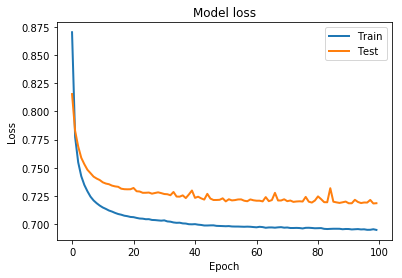

In [12]:
plt.plot(history['loss'], linewidth=2, label='Train')
plt.plot(history['val_loss'], linewidth=2, label='Test')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

seems like our model work nicely, now we will make the predictions.

In [13]:
pred = autoencoder.predict(test_x)

Model evaluation

In [14]:
mse = np.mean(np.power(test_x - pred, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': test_y})

In [15]:
error_df.Reconstruction_error.values

array([77.24055566,  0.87190388,  0.24955684, ...,  0.51939849,
        0.24887566,  0.1524689 ])

we will use a threshold to separate between fraudulent transactions and legitimate transactions

In [16]:
threshold_fixed = 5
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
matrix = confusion_matrix(error_df.True_class, pred_y)

In [17]:
tpos = matrix[0][0]
fneg = matrix[1][1]
fpos = matrix[0][1]
tneg = matrix[1][0]

In [18]:
print( 'Accuracy: '+ str(np.round(100*float(tpos+fneg)/float(tpos+fneg + fpos + tneg),2))+'%')
print( 'Cohen Kappa: '+ str(np.round(cohen_kappa_score(error_df.True_class, pred_y),3)))
print("Sensitivity/Recall for Model : {}".format(round(recall_score(error_df.True_class, pred_y), 2)))
print("F1 Score for Model : {}".format(round(f1_score(error_df.True_class, pred_y), 2)))

Accuracy: 98.88%
Cohen Kappa: 0.162
Sensitivity/Recall for Model : 0.69
F1 Score for Model : 0.16


This work is inspired by : https://www.datascience.com/blog/fraud-detection-with-tensorflow